In this notebook I realize the three following exercises:

   Q1: BSM Hedging
    
   -We test the library financepy created by Dominic O'Kane used for the pricing of financial Products.
   
   -We create a function that simulates the delta hedging of a European call option with different frequency and we compute the hedging error
   
   -We compute the mean, variance and mean absolute error of hedging error with regard to frequency of hedging
   
   Q2: LeLand Adjustment
   
   -We add round trip bid-ask transaction costs and analyze their effects on hedging error, hedging costs and therefore option prices
   
   Q3: Implied density of Terminal Stock price with Breeden-Litzenberger
   
   -We determine the implied density of the terminal stock price from the volatility skew using Breeden-Litzenberger formula
   
   -We price a digital call option using two methods:
   
       - BS formula
       
       - Using the probability density function implied by the volatility smile
       
   

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as mth

In [2]:
from financepy.utils import *
from financepy.products.equity import *

####################################################################
# FINANCEPY BETA Version 0.260 - This build:  22 Nov 2022 at 13:42 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



# Question 1: BSM Hedging

a) Install financepy and using the documentation and notebook examples, determine how
to value an Equity Vanilla Option.

In [3]:
def vanillaPrice(K, S, r, sigma, q, T, valuation_date, flag):

    #Define dates
    expiry_date = valuation_date.add_years(T)
    
    #Define the models to be used for risk-free rate, dividend and vol
    discount_curve = DiscountCurveFlat(valuation_date, r, FrequencyTypes.CONTINUOUS)
    dividend_curve = DiscountCurveFlat(valuation_date, q)
    model = BlackScholes(sigma)
    
    if flag == 'call':
        call_option = EquityVanillaOption(expiry_date, K, OptionTypes.EUROPEAN_CALL)
        optPrice = call_option.value(valuation_date, S, discount_curve, dividend_curve, model)
        vanillaPrice.delta = (valuation_date, S, discount_curve, dividend_curve, model)
    elif flag == 'put':
        put_option = EquityVanillaOption(expiry_date, K, OptionTypes.EUROPEAN_PUT)
        optPrice = put_option.value(valuation_date, S, discount_curve, dividend_curve, model)
        vanillaPrice.delta = (valuation_date, S, discount_curve, dividend_curve, model)
    else :
        print('Please define flag as call or put')

    return optPrice

In [4]:
# Checking if Put Call Parity Holds to ensure pricing is correct
c = vanillaPrice(110, 100, 0.02, 0.2, 0.00, 1, Date(12, 12, 2022), "call")
p = vanillaPrice(110, 100, 0.02, 0.2, 0.00, 1, Date(12, 12, 2022), "put")
parity = 100 - 110 * mth.exp((-0.02) * 1)
print("C - P: ", c - p)
print("S0 - PV(K): ", parity)

C - P:  -7.821854063743061
S0 - PV(K):  -7.821854063743075


b) Use financepy to calculate the option delta

In [5]:
def vanillaDelta(K, S, r, sigma, q, T, valuation_date, flag):
    
    #Define dates
    expiry_date = valuation_date.add_years(T)
    
    #Define the models to be used for risk-free rate, dividend and vol
    discount_curve = DiscountCurveFlat(valuation_date, r, FrequencyTypes.CONTINUOUS)
    dividend_curve = DiscountCurveFlat(valuation_date, q)
    model = BlackScholes(sigma)
    
    if flag == 'call':
        call_option = EquityVanillaOption(expiry_date, K, OptionTypes.EUROPEAN_CALL)
        optDelta = call_option.delta(valuation_date, S, discount_curve, dividend_curve, model)
    elif flag == 'put':
        put_option = EquityVanillaOption(expiry_date, K, OptionTypes.EUROPEAN_PUT)
        optDelta = put_option.delta(valuation_date, S, discount_curve, dividend_curve, model)
    else :
        print('Please define flag as call or put')
        
    return optDelta

In [6]:
#Testing Delta for ATM Forward option
cDelta = vanillaDelta(100 * mth.exp(0.02), 100, 0.02, 0.2, 0.00, 1, Date(12, 12, 2022), "call")
pDelta = vanillaDelta(100 * mth.exp(0.02), 100, 0.02, 0.2, 0.00, 1, Date(12, 12, 2022), "put")
print("Delta of ATM Forward Call", cDelta)
print("Delta of ATM Forward Put", pDelta)

Delta of ATM Forward Call 0.5398278962083318
Delta of ATM Forward Put -0.4601721037916682


c) In Python in a notebook, write a function called OptionSim that simulates the
delta hedging of a European call option from trade date until expiry. It should use
the function in (a) for calculating the option price and in (b) delta. The function
inputs must include the option strike K, spot price of the stock S, risk-free rate
r, the stock price drift µ (we do not assume that the stock grows at r), volatility σ and years to expiry T...

In [7]:
from scipy import stats
from datetime import date

In [8]:
np.random.seed(2410)

# I compute the minimum necessary data in the loop to make the code fast: only delta, cashbalance & Stock Price are computed at each step
def optionSim(K, S, r, mu, sigma, q, T, valuation_date, n_steps):
    
    #Call option initial pricing
    expiry_date = valuation_date.add_years(T)
    discount_curve = DiscountCurveFlat(valuation_date, r, FrequencyTypes.CONTINUOUS)
    dividend_curve = DiscountCurveFlat(valuation_date, q)
    model = BlackScholes(sigma)
    call_option = EquityVanillaOption(expiry_date, K, OptionTypes.EUROPEAN_CALL)  
    
    Cprice = call_option.value(valuation_date, S, discount_curve, dividend_curve, model)
    
    #Set up variables
    dt = T/n_steps
    delta = call_option.delta(valuation_date, S, discount_curve, dividend_curve, model) # delta at time t0
    cash = Cprice - delta * S

    for i in range (0, n_steps):
        
        #Simulating lognormal stock price process
        eps = np.random.normal(0, 1) # eps=random.normal() simulate outcome of N(0,1)
        S = S*mth.exp((mu-0.5*sigma ** 2)*dt+sigma*mth.sqrt(dt)*eps)
        
        #Updating discount curve and div curve with new valuation date
        valuation_date = valuation_date.add_years(dt)
        discount_curve = DiscountCurveFlat(valuation_date, r, FrequencyTypes.CONTINUOUS)
        dividend_curve = DiscountCurveFlat(valuation_date, q)
        
        #Computing new delta -> if higher: buy shares, lower: sell shares
        hedgingPortfolio = cash * mth.exp(r * dt) + delta * S #cash balance capitalized + value of shares
        delta = call_option.delta(valuation_date, S, discount_curve, dividend_curve, model)
        cash = (hedgingPortfolio - delta * S) #new cash balance after delta adjusting
        
    #hedgingPortfolio = cash * mth.exp(r * dt) + delta * S
    
    result = (S, max(S-K,0), delta, cash, hedgingPortfolio, hedgingPortfolio - max(S - K, 0))
    #1.Stock price at maturity, 2. Payoff, 3.Delta at maturity, 4. Final cash balance, 5. Heding Portfolio, 6. Hedging Error
    return result

In [9]:
K, S, r, mu, sigma, q, T = 100, 100, 0.02, 0.02, 0.2, 0.00, 1
valuation_date = Date(25,11,2022)

In [10]:
optionSim(K, S, r, mu, sigma, q, T, valuation_date, 12) #K, S, r, mu, sigma, q, T, valuation_date, n_steps

(84.58765783993181,
 0,
 0.0,
 1.2209907797708397,
 1.2209907797708397,
 1.2209907797708397)

d) Write another function that calls the previous OptionSim function and which can then
be used to calculate the hedging error over 1,000 different paths. You must provide a
clear and easy-to-understand listing of your code in the answer

In [11]:
def hedgingError(K, S, r, mu, sigma, q, T, valuation_date, n_steps):
    
    hedgingError = []
    
    for i in range(100):
        simulation_result = optionSim(K, S, r, mu, sigma, q, T, valuation_date, n_steps)
        hedgingError.append(simulation_result[5])
    
    average = sum(hedgingError) / len(hedgingError)
    return average

In [13]:
hedgingError(K, S, r, mu, sigma, q, T, valuation_date, 52)

0.08779324382829809

e) Consider a call option with S(0) = 100, K = 100, r = 5%, T = 1.0 and σ = 20%. Assume here that µ = r. For this option, make a scatterplot of the hedging error (yaxis) versus the terminal stock price (x-axis) for N = 12 (monthly), N = 52 (weekly) and N = 252 (daily). Use different symbols or colours to distinguish the points.

In [14]:
K, S, r, mu, sigma, q, T, valuation_date = 100, 100, 0.05, 0.05, 0.2, 0.00, 1, Date(12,12,2022)

In [15]:
def plotHE(K, S, r, mu, sigma, q, T, valuation_date, n_steps, color):
    
    hedgingError = []
    ST = []
    
    for i in range(100):
        simulation_result = optionSim(K, S, r, mu, sigma, q, T, valuation_date, n_steps)
        ST.append(simulation_result[0])
        hedgingError.append(simulation_result[5])
        plt.scatter(ST[-1], hedgingError[-1], color = color)
        plt.ylabel("Hedging Error")
        plt.xlabel("Stock price at maturity")
        
    
    #plt.scatter(ST, hedgingError, color = color)

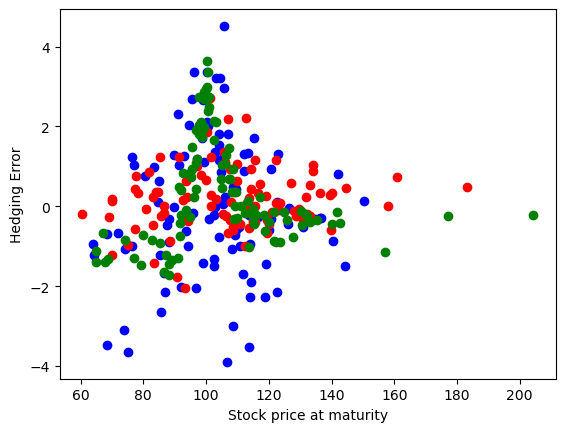

In [16]:
plotHE(K, S, r, mu, sigma, q, T, valuation_date, 12, "blue")
plotHE(K, S, r, mu, sigma, q, T, valuation_date, 52, "red")
plotHE(K, S, r, mu, sigma, q, T, valuation_date, 252, "green")

The shape formed by the scatterplot is as expected. Indeed the hedging error is positive when the underlying has not moved a lot.
Being short of the call, we are short volatility and therefore profit from low volatility.


In [17]:
def plotReplicatingError(K, S, r, mu, sigma, q, T, valuation_date, n_steps, color):
    
    hedgingPtf = []
    ST = []
    payoff = []
    
    for i in range(100):
        simulation_result = optionSim(K, S, r, mu, sigma, q, T, valuation_date, n_steps)
        ST.append(simulation_result[0])
        hedgingPtf.append(simulation_result[4])
        payoff.append(simulation_result[1])
        plt.scatter(ST[-1], hedgingPtf[-1], color = color)
        plt.scatter(ST[-1], payoff[-1], color = 'red')
        plt.ylabel("Hedging Portfolio")
        plt.xlabel("Stock price at maturity")

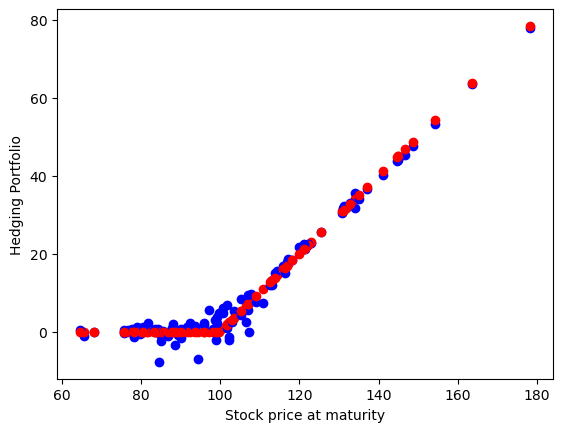

In [18]:
plotReplicatingError(K, S, r, mu, sigma, q, T, valuation_date, 12, "blue")

f) For each value of N also calculate the mean and variance of this option hedging error over 1,000 different paths. You can use this to generate the answers to the remaining parts of this question. Present this in a simple table format

In [19]:
def HEStats(K, S, r, mu, sigma, q, T, valuation_date, n_steps, n_paths):
    
    hedgingError = []
    
    for i in range(n_paths):
        
        simulation_result = optionSim(K, S, r, mu, sigma, q, T, valuation_date, n_steps)
        hedgingError.append(simulation_result[5])
        
    meanHE =  sum(hedgingError) / len(hedgingError)
    varHE = np.var(hedgingError)
    
    stats = (meanHE, varHE)
    
    return stats

In [20]:
HE12 = HEStats(K, S, r, mu, sigma, q, T, valuation_date, 12, 100)
HE52 = HEStats(K, S, r, mu, sigma, q, T, valuation_date, 52, 100)
HE252 = HEStats(K, S, r, mu, sigma, q, T, valuation_date, 252, 100)

mean = [HE12[0], HE52[0], HE252[0]]
variance = [HE12[1], HE52[1], HE252[1]]

HEstatistics = pd.DataFrame(({"Mean": mean, 'Variance' : variance}), index = ['N = 12', 'N = 52', 'N = 252'])
HEstatistics

,Mean,Variance
N = 12,-0.038091,4.130634
N = 52,-0.065433,1.397675
N = 252,0.283853,1.721847


g) For the same call option, calculate the mean absolute error value and the variance of the hedging error for µ = 2.5%, 5.0%, 7.5%, 10% by sampling P = 10, 000 hedging paths using N = 52. Show the results in a table. What does this tell you ?


In [21]:
drift = []
mean = []
variance = []

for i in range(4): 
    mu = 0.025 + i * 0.025
    simulation_result = HEStats(K, S, r, mu, sigma, q, T, valuation_date, 52, 100)
    drift.append(mu)
    mean.append(simulation_result[0])
    variance.append(simulation_result[1])
    
HE = pd.DataFrame({'Drift': drift, "Mean": mean, 'Variance' : variance})
HE

,Drift,Mean,Variance
0,0.025,-0.114390,0.943881
1,0.050,-0.094170,0.798474
2,0.075,-0.019699,0.702865
3,0.100,-0.053315,0.549357


# Question 2: Implementation of Transaction Costs with Leland adjustment

a) Starting with the code from Question 1, amend your code to have a round trip bidask transaction cost of µ% for each share purchase and sale (you buy at a price of
S · (1 + µ/2) and sell at a price of S · (1 − µ/2)). The transaction costs of each trade
will be taken out of the cash account

In [22]:
# I compute the minimum necessary data in the loop to make the code fast: only delta, cashbalance & Stock Price are computed at each step
def optionSimWithCost(K, S, r, mu, sigma, q, T, valuation_date, spread, n_steps):
    
    #Call option pricing
    expiry_date = valuation_date.add_years(T)
    discount_curve = DiscountCurveFlat(valuation_date, r, FrequencyTypes.CONTINUOUS)
    dividend_curve = DiscountCurveFlat(valuation_date, q)
    model = BlackScholes(sigma)
    call_option = EquityVanillaOption(expiry_date, K, OptionTypes.EUROPEAN_CALL)             
    Cprice = call_option.value(valuation_date, S, discount_curve, dividend_curve, model)
    
    #Set up variables
    dt = T/n_steps
    
    #Initializing lists : option prime - delta * S
    St = [S] # stock price at time t
    deltat = [call_option.delta(valuation_date, S, discount_curve, dividend_curve, model)] # delta at time t
    cashbalance = [Cprice - deltat[-1] * S * (1 + spread/2)]

    for i in range (n_steps):
        
        #Simulating lognormal stock price process
        eps = np.random.normal(0, 1) # eps=random.normal() simulate outcome of N(0,1)
        S = S*mth.exp((mu-0.5*sigma ** 2)*dt+sigma*mth.sqrt(dt)*eps)
        St.append(S)
        
        #Updating discount curve and div curve with new valuation date
        valuation_date = valuation_date.add_years(dt)
        discount_curve = DiscountCurveFlat(valuation_date, r, FrequencyTypes.CONTINUOUS)
        dividend_curve = DiscountCurveFlat(valuation_date, q)
        
        deltat.append(call_option.delta(valuation_date, S, discount_curve, dividend_curve, model))
        
        if deltat[-1] < deltat[-2]:
        # lower delta, sell shares at the bid
            cashbalance.append(cashbalance[-1] - (deltat[-1] - deltat[-2]) * S * (1 - spread/2))
        
        if deltat[-1] > deltat[-2]:
        # higher delta, buy shares at the ask
            cashbalance.append(cashbalance[-1] - (deltat[-1] - deltat[-2]) * S * (1 + spread/2))
    
    result = (St[-1], max(St[-1]-K,0), deltat[-1], cashbalance[-1], S * deltat[-1] + cashbalance[-1], S * deltat[-1] + cashbalance[-1] - max(St[-1] - K, 0))

    return result

In [24]:
spread = 0.01

In [25]:
optionSimWithCost(K, S, r, mu, sigma, q, T, valuation_date, spread, 12)

(73.8464765612491,
 0,
 0.0,
 -0.9592931687452566,
 -0.9592931687452566,
 -0.9592931687452566)

b) Calculate the mean hedging error value for (i) N = 12, 52, 250 with t =
0.5%, 1.0%, 2.0% by sampling across P = 1, 000 hedging paths. Show the results
in a table. Explain your results

In [26]:
def HEStatsWithCost(K, S, r, mu, sigma, q, T, valuation_date, spread, n_steps, n_paths):
    
    hedgingError = []
    
    for i in range(n_paths):
        
        simulation_result = optionSimWithCost(K, S, r, mu, sigma, q, T, valuation_date, spread, n_steps)
        hedgingError.append(simulation_result[5])
        
    meanHE =  sum(hedgingError) / len(hedgingError)
    #varHE = np.var(hedgingError)
    
    stats = (meanHE)
    #stats = (meanHE, varHE)
    
    return stats

In [27]:
tc = []
mean12 = []
mean52 = []
mean252 = []

for i in [0.005, 0.01, 0.02]: 

        spread = i
        tc.append(spread)
        simulation_result = HEStatsWithCost(K, S, r, mu, sigma, q, T, valuation_date, spread, 12, 100) 
        mean12.append(simulation_result)
        simulation_result = HEStatsWithCost(K, S, r, mu, sigma, q, T, valuation_date, spread, 52, 100) 
        mean52.append(simulation_result)
        simulation_result = HEStatsWithCost(K, S, r, mu, sigma, q, T, valuation_date, spread, 252, 100) 
        mean252.append(simulation_result)
        
        #variance.append(simulation_result[1])
    
HE = pd.DataFrame({'Transaction cost': tc, "Mean (12)": mean12, "Mean (52)": mean52, 'Mean (252)': mean252})
HE

,Transaction cost,Mean (12),Mean (52),Mean (252)
0,0.005,2.831036,2.445610,1.884096
1,0.010,2.242448,1.644899,0.222803
2,0.020,1.326315,-0.216835,-2.192704


c) Leland (Journal of Finance, 1985) showed that the cost of hedging taking into account
hedging costs is equivalent to adjusting the volatility as follows:
    
    vol adjusted = vol * ( 1 + sqrt((2/pi)*(mu/sigma)) * sqrt(N) ) ** 1/2
    
Compare the price increase you obtained with the prices using this adjusted volatility
in Black-Scholes.

In [28]:
def vanillaPriceLeland(K, S, r, sigma, q, T, valuation_date, n_steps, flag):

    #Define dates
    voladjusted = sigma * ( 1 + mth.sqrt((2/np.pi)*(mu/sigma)) * mth.sqrt(n_steps) ) ** 1/2
    expiry_date = valuation_date.add_years(T)
    
    #Define the models to be used for risk-free rate, dividend and vol
    discount_curve = DiscountCurveFlat(valuation_date, r, FrequencyTypes.CONTINUOUS)
    dividend_curve = DiscountCurveFlat(valuation_date, q)
    model = BlackScholes(voladjusted)
    
    if flag == 'call':
        call_option = EquityVanillaOption(expiry_date, K, OptionTypes.EUROPEAN_CALL)
        optPrice = call_option.value(valuation_date, S, discount_curve, dividend_curve, model)
        vanillaPrice.delta = (valuation_date, S, discount_curve, dividend_curve, model)
    elif flag == 'put':
        put_option = EquityVanillaOption(expiry_date, K, OptionTypes.EUROPEAN_PUT)
        optPrice = put_option.value(valuation_date, S, discount_curve, dividend_curve, model)
        vanillaPrice.delta = (valuation_date, S, discount_curve, dividend_curve, model)
    else :
        print('Please define flag as call or put')

    return optPrice

In [29]:
#BS Price of a call option, S = 100, K = 100, vol = 0.2, r = 0.05, T = 1
vanillaPrice(100, 100, 0.05, 0.2, 0.00, 1, Date(15, 12, 2022),'call')

10.450575619322272

In [30]:
# Price of the call option with Leland adjustment for monthly hedging (N=12)
vanillaPriceLeland(100, 100, 0.05, 0.2, 0.00, 1, Date(15, 12, 2022), 12,'call')

14.058268572460422

In [31]:
# Price with Leland adjustment for monthly hedging (N=52)
vanillaPriceLeland(100, 100, 0.05, 0.2, 0.00, 1, Date(15, 12, 2022), 52,'call')

22.04927971966848

In [32]:
# Price with Leland adjustment for monthly hedging (N=252
vanillaPriceLeland(100, 100, 0.05, 0.2, 0.00, 1, Date(15, 12, 2022), 252,'call')

39.68998260452309

## Question 3
### Determining the implied density of the terminal stock price from the volatility skew

a) Suppose that we have managed to fit the 1-year volatility smile of the equity option
market using a function
σ(x) = ax2 + bx + c
where x is the ”moneyness” (x = K/S(0)) and the initial stock price S(0) = 100
and a = 0.025, b = −0.225 and c = 0.50. Build a Python function that extracts the
market-implied distribution of S(T) at a 1-year horizon from σ(x) using the Breedon Litzenberger formula we derived in class. You should use FinancePy to calculate the
option prices

In [33]:
def vanillaPrice(K, S, r, sigma, q, T, valuation_date, flag):

    #Define dates
    expiry_date = valuation_date.add_years(T)
    
    #Define the models to be used for risk-free rate, dividend and vol
    discount_curve = DiscountCurveFlat(valuation_date, r, FrequencyTypes.CONTINUOUS)
    dividend_curve = DiscountCurveFlat(valuation_date, q)
    model = BlackScholes(sigma)
    
    if flag == 'call':
        call_option = EquityVanillaOption(expiry_date, K, OptionTypes.EUROPEAN_CALL)
        optPrice = call_option.value(valuation_date, S, discount_curve, dividend_curve, model)
        vanillaPrice.delta = (valuation_date, S, discount_curve, dividend_curve, model)
    elif flag == 'put':
        put_option = EquityVanillaOption(expiry_date, K, OptionTypes.EUROPEAN_PUT)
        optPrice = put_option.value(valuation_date, S, discount_curve, dividend_curve, model)
        vanillaPrice.delta = (valuation_date, S, discount_curve, dividend_curve, model)
    else :
        print('Please define flag as call or put')

    return optPrice

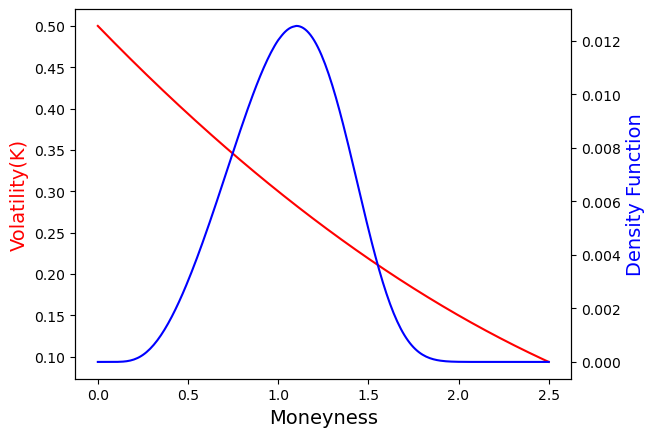

In [34]:
S, r, q, T = 100, 0.05, 0.00, 1
valuation_date = Date(13, 12, 2022) #Today

#creating one index (strikes) and the IV and option call price with respect to the strikes
strikes, volatility, optPrice, moneyness = [], [], [], []

a, b, c = 0.025, -0.225, 0.5 #fixing factors that fit the vol smile

for i in range(251): 
    K = i
    x = K/S
    vol = a * x ** 2 + b * x + c  #volatility with respect to the moneyness
    cPrice = vanillaPrice(K, S, r, vol, q, T, valuation_date, 'call')
    optPrice.append(cPrice), strikes.append(K),volatility.append(vol), moneyness.append(x)

#Once we have priced the set call options with the volatility function, we determine the implied probability distribution g(K)
discountFactor = mth.exp(-r*T); d2VdK2 = [0]; density = [0]; cdf = [0]; cumul = 0

for i in range(1, 250):
    
    d2VdK2.append((optPrice[i + 1] - 2 * optPrice[i] + optPrice[i - 1]) / (strikes[i] - strikes[i-1]) ** 2)
    density.append( (1 / discountFactor) * (optPrice[i + 1] - 2 * optPrice[i] + optPrice[i - 1]) / (strikes[i] - strikes[i-1]) ** 2)
    cumul = cumul + density[i]
    cdf.append(cumul)
    
# impossible to compute the last value but we need to match the number of lines
d2VdK2.append(0); density.append(0); cdf.append(1)

df = pd.DataFrame({'Moneyness': moneyness, 'Volatility(K)': volatility, 'Price': optPrice, 'd2V/dK2': d2VdK2, 'density': density, 'cdf': cdf}, strikes)
df.index.name = 'Strike K'

#df.plot(y = 'Volatility(K)', use_index=True ) # Plotting Volatility (y) with regard to index (x)

fig,ax = plt.subplots()
ax.plot(df['Moneyness'], df['Volatility(K)'], color = 'red')
ax.set_xlabel("Moneyness", fontsize = 14)
ax.set_ylabel("Volatility(K)", color = 'red', fontsize = 14)

ax2 = ax.twinx()
ax2.plot(df['Moneyness'], df['density'], color = 'blue')
ax2.set_ylabel('Density Function', color = 'blue', fontsize = 14)
plt.show()


(b) A digital call option pays $1 if S(T) > K and zero otherwise. Using the probability
density function implied by this volatility smile, calculate a table of prices of the 1-
year European digital call option with strikes at K = 60, 80, 100, 120, 140. Assume
that r = 5% and q = 0.0%.

In [35]:
from scipy.stats import norm

In [36]:
digitPriceCDF = []; strikes = []

for i in range (5):
    K = 60 + i * 20
    digitPrice = 1- discountFactor * (df['cdf'].values[K])
    digitPriceCDF.append(digitPrice); strikes.append(K)

print(digitPriceCDF)
digitCDF = pd.DataFrame({'Digit Price CDF': digitPriceCDF}, strikes)
digitCDF.index.name = "Strikes"
digitCDF

[0.9263845938144115, 0.794543457061593, 0.5913695112897308, 0.3559866886725479, 0.16414041353780506]


,Digit Price CDF
Strikes,
60,0.926385
80,0.794543
100,0.591370
120,0.355987
140,0.164140


(c) Price the same set of digital call options using the Black-Scholes pricing formula for
digital call options in the lecture notes or use FinancePy.

In [37]:
S, r, q, T = 100, 0.05, 0.00, 1
a, b, c = 0.025, -0.225, 0.5

strikes, volatility, digitPriceBS, moneyness = [], [], [], []

for i in range(5):
    K = 60 + i * 20
    x = K/S
    vol = a * x ** 2 + b * x + c
    d2 = ( np.log(S/K) + ( r - vol**2 / 2) * T) / ( vol * sqrt(T) )
    nd2 = norm.cdf(d2)
    digitC = mth.exp(-r * T) * nd2
    
    strikes.append(K); volatility.append(vol); digitPriceBS.append(digitC); moneyness.append(x)
    
digitBS = pd.DataFrame({'Strike': strikes, 'Moneyness': moneyness, 'Volatility': volatility, 'Digit Price BS': digitPriceBS, 'Digit Price CDF': digitPriceCDF })
digitBS

,Strike,Moneyness,Volatility,Digit Price BS,Digit Price CDF
0,60,0.6,0.374,0.861176,0.926385
1,80,0.8,0.336,0.704398,0.794543
2,100,1.0,0.300,0.481939,0.591370
3,120,1.2,0.266,0.251315,0.355987
4,140,1.4,0.234,0.085536,0.164140


(d) Explain why the results of (b) and (c) do not agree with each other and explain which
prices you think are more correct.

In [38]:
Error = []
for i in range (5):
    error = digitBS['Digit Price BS'].values[i] - digitCDF['Digit Price CDF'].values[i]
    Error.append(error)

digitBS['BS Error'] = Error
digitBS

#We observe that BS is overpricing with respect to the CDF method
    

,Strike,Moneyness,Volatility,Digit Price BS,Digit Price CDF,BS Error
0,60,0.6,0.374,0.861176,0.926385,-0.065208
1,80,0.8,0.336,0.704398,0.794543,-0.090146
2,100,1.0,0.300,0.481939,0.591370,-0.109430
3,120,1.2,0.266,0.251315,0.355987,-0.104672
4,140,1.4,0.234,0.085536,0.164140,-0.078605


Black Scholes model assumes a log normal distribution of prices.
While we have modified the model and injected the proper volatilities, strikes dependent (σ(x) = ax2 + bx + c ), the implied-price distribution is not changed in Black Scholes.

In our case, higher volatilities for lower strikes mean that the distribution has fatter tails on the left, and so, that we have higher probability for lower prices, than the probability implied by the lognormal stock pricess process.

(e) Calculate the value of a put option with strike 100 which only pays out if the stock
falls below $60 at expiry (this is a European and not a path dependent option). Explain
carefully and clearly how this was done.

In [39]:
# First we price a put strike 100

S, K, r, q, T = 100, 100, 0.05, 0.00, 1
valuation_date = Date(13, 12, 2022) 

#creating one index (strikes) and the IV and option call price with respect to the strikes
strikes, volatility, optPrice, moneyness = [], [], [], []

a, b, c = 0.025, -0.225, 0.5 #fixing factors that fit the vol smile

x = K/S
vol = a * x ** 2 + b * x + c  #volatility with respect to the moneyness
pPrice = vanillaPrice(K, S, r, vol, q, T, valuation_date, 'put')
print(pPrice)

9.354187384228622


In [40]:
#We know that the put only pays off if it ends up below the barrier level at maturity
#Therefore, we multiply the price of the put by the probability that it is actually exercised
#This probability discounted is the price of the digit Put strike 60

In [41]:
S, r, q, T = 100, 0.05, 0.00, 1
a, b, c = 0.025, -0.225, 0.5

strikes, volatility, digitPriceBS, moneyness = [], [], [], []


K = 60
x = K/S
vol = a * x ** 2 + b * x + c
d2 = ( np.log(S/K) + ( r - vol**2 / 2) * T) / ( vol * sqrt(T) )
nd2 = norm.cdf(d2)
digitP = mth.exp(-r * T) * (1 - nd2)

print(digitP)

0.0900529396112726


In [42]:
digitPutPrice = digitP * pPrice
print(digitPutPrice)

0.8423720716244681


In [43]:
#We find a price of 0.84, which is way lower than the put price.